# Retraining MobileNet V2 for Person Detection and ESP32 Compatibility
## Retraining MobileNet V2 for Person Detection
+ Utilize a pretrained MobileNet V2 model designed to detect 1000 classes.
+ Retrain the model to detect the presence of a person in an image.
## Modifying the Model for ESP32 Compatibility
+ Convert the model input to accept flat array images.
+ Resize images to match the model's input size.
+Quantize the model for efficient execution on the ESP32.

## Training

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.config.threading.set_inter_op_parallelism_threads(
    8
)
tf.config.threading.get_inter_op_parallelism_threads()

8

In [3]:
tf.config.threading.set_intra_op_parallelism_threads(8)
tf.config.threading.get_intra_op_parallelism_threads()

8

## setup dataset

In [4]:
BATCH_SIZE = 32


In [5]:
IMAGE_CHANNELS = 3

# input image (ie image from esp 32 looks size)
IMAGE_HEIGHT = 240
IMAGE_WIDTH = 240
IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

# pretrained MobileNetV2 model image size
BASE_MODEL_IMAGE_HEIGHT = 96
BASE_MODEL_IMAGE_WIDTH = 96
BASE_MODEL_IMAGE_SHAPE = (BASE_MODEL_IMAGE_HEIGHT, BASE_MODEL_IMAGE_WIDTH, IMAGE_CHANNELS)

# final model input shape (flat)
MODEL_INPUT_SHAPE = (IMAGE_CHANNELS * IMAGE_HEIGHT * IMAGE_WIDTH)

dict_keys(['image', 'image/filename', 'image/id', 'objects'])
dict_keys(['image', 'image/filename', 'image/id', 'objects'])
dict_keys(['image', 'label'])
Person present: [[ True]]


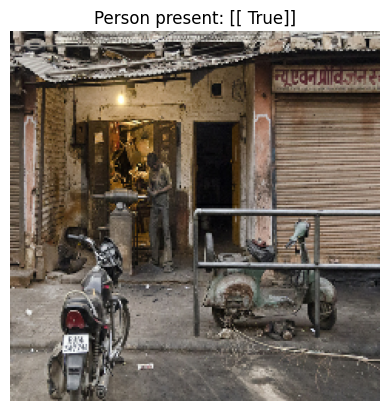

(32, 1, 172800)
(32, 1, 1)
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1, 172800), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.bool, name=None))>


In [6]:
# Data set file location
data_dir = 'G:\ml_datasets\coco'

# Load the dataset with the specified data directory
ds_train, ds_validation = tfds.load('coco/2017', split=['train','validation'], data_dir=data_dir)

# Define the label for 'person' in the dataset
PERSON_LABEL = 0  # Assuming 'person' has label 1, adjust this according to your dataset
#Function to check if a person is in the image
def has_person(example):
    print(example.keys())
    objects = example['objects']['label']
    person_present = tf.reduce_any(tf.equal(objects, PERSON_LABEL))
    example['person_present'] = tf.reshape(person_present, (1,1))
    output = {'image': example['image'], 'label': example['person_present']}
    return output
# resize image
def format_image(example):
    # Resize the image
    example["image"] = tf.image.resize(example["image"], [IMAGE_HEIGHT, IMAGE_WIDTH])
    # Normalize the image
    example["image"] = tf.cast(example["image"], tf.float32) / 255.0
    return example

# flatten image
def flatten_image(example):
    example["image"] = tf.reshape(example["image"], (1,IMAGE_CHANNELS * IMAGE_HEIGHT * IMAGE_WIDTH,))
    return example
    
# tuple format
def tuple_format(example):
    return (example["image"], example["label"])

# Apply the mapping function to the dataset
ds_train = ds_train.map(has_person)
ds_validation = ds_validation.map(has_person)
ds_train = ds_train.map(format_image)
ds_validation = ds_validation.map(format_image)

# Iterate through the dataset and print an example
for example in ds_train.take(1):
    print(example.keys())
    image, person_present = example["image"], example["label"]
    print(f"Person present: {person_present.numpy()}")
    
    # Display the image using Matplotlib
    plt.imshow(image)
    plt.title(f"Person present: {person_present}")
    plt.axis('off')
    plt.show()

ds_train = ds_train.map(flatten_image)
ds_validation = ds_validation.map(flatten_image)
ds_train = ds_train.map(tuple_format)
ds_validation = ds_validation.map(tuple_format)


def data_generator(ds):
    for example in ds:
        yield example
    
genned = tf.data.Dataset.from_generator(
    lambda: data_generator(ds_validation),
    output_signature=(
        tf.TensorSpec(shape=(None,IMAGE_CHANNELS*IMAGE_WIDTH*IMAGE_HEIGHT ), dtype=tf.float32),
        tf.TensorSpec(shape=(None,1), dtype=tf.int64)
)
    
)
ds_train_batched = ds_train.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
for example in ds_train_batched.take(1):
    print(example[0].shape)
    print(example[1].shape)
print(ds_train_batched)

# Selecting a base model
It is often easier to take an exist model and retrain for more specific tasks
This example use a pretrained version of mobilenetv2 as a feature extrature
The confulation filters are able to generate many feature from the image the could be things like red vertical lines, yello dots etc
We will add new layers to take the input and predrict our clases

Note not all parametes this kera function have pretrianed weights.
## tranfer learing https://www.tensorflow.org/tutorials/images/transfer_learning


In [7]:
base_model =tf.keras.applications.MobileNetV2(
        input_shape=BASE_MODEL_IMAGE_SHAPE,
        alpha=0.35,
        include_top=False,# the top is the last layer of the model (the classifier) we don't want to include it we will train our own final layer
        weights="imagenet",
        input_tensor=None,
        pooling=None,
        classes=1000,
        classifier_activation=None,
    )
# Freeze the base model because we only want to train the new classifier
# We don't want to train the base model because it has already learned many features
# training new features is more difficult than training the classifier and would require more data
base_model.trainable = False
#base_model.summary()

In [8]:
# TODO might be better to define the base model with the flat input to make batching work
# this is not goinh to work as is it will provide flat input to the shaped input of the base mmodel

# need to know batch size for some layers?
batch = next(iter(ds_train_batched))
print(batch)
image_batch =batch[0]

reshape_layer = tf.keras.layers.Reshape(IMAGE_SHAPE)

resize_layer = tf.keras.layers.Resizing(
    BASE_MODEL_IMAGE_HEIGHT,
    BASE_MODEL_IMAGE_WIDTH,
    interpolation='nearest',#"bilinear", "nearest" are compatible with tf micro
    crop_to_aspect_ratio=True
    )

feature_batch = base_model(resize_layer(reshape_layer(image_batch)))
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# new bnnary classifier layer
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='label')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(<tf.Tensor: shape=(32, 1, 172800), dtype=float32, numpy=
array([[[0.9738563 , 0.9977124 , 0.98366016, ..., 0.49641055,
         0.5052349 , 0.5049081 ]],

       [[0.953268  , 0.9611111 , 0.953268  , ..., 0.21699339,
         0.1787582 , 0.11307181]],

       [[0.40293437, 0.26156726, 0.23184913, ..., 0.49825838,
         0.46166372, 0.4523092 ]],

       ...,

       [[0.5686275 , 0.53333336, 0.31764707, ..., 0.05294118,
         0.03333334, 0.01764706]],

       [[0.3077015 , 0.19764093, 0.1292824 , ..., 0.49923456,
         0.41916624, 0.31428978]],

       [[0.5978186 , 0.648799  , 0.7742892 , ..., 0.19215687,
         0.14509805, 0.08235294]]], dtype=float32)>, <tf.Tensor: shape=(32, 1, 1), dtype=bool, numpy=
array([[[False]],

       [[ True]],

       [[ True]],

       [[False]],

       [[False]],

       [[False]],

       [[ True]],

       [[ True]],

       [[False]],

       [[False]],

       [[False]],

       [[ True]],

       [[ True]],

       [[False]],

       [[

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
flat_input = tf.keras.layers.Input(shape=(IMAGE_CHANNELS * IMAGE_HEIGHT * IMAGE_WIDTH,), name='image')
x = reshape_layer(flat_input)
x = resize_layer(x)
#x = data_augmentation(resize)
#x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(flat_input, outputs, name='person_detector')
model.summary()
input_shape = model.input_shape
print(f'Model input shape: {input_shape}')

Model: "person_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 172800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.35_96             │ (None, 3, 3, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ label (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,489 (1.57 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 410,208 (1.56 MB)

Model input shape: (None, 172800)


In [11]:
# model = tf.keras.models.Sequential([
#   flat_input,
#   reshape_layer,
#   resize_layer,
#   base_model,
#  global_average_layer,
#   prediction_layer,
# ])
# # T
# model.summary()


In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [13]:
initial_epochs = 10

model.evaluate(ds_validation)

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.5245 - loss: 0.8127


[0.7982752323150635, 0.5364000201225281]

In [17]:
history = model.fit(ds_train,
                    epochs=initial_epochs,
                    validation_data=ds_validation
                    )

Epoch 1/10
118287/118287 ━━━━━━━━━━━━━━━━━━━━ 772s 7ms/step - accuracy: 0.8004 - loss: 0.4238 - val_accuracy: 0.8032 - val_loss: 0.4244
Epoch 2/10
118287/118287 ━━━━━━━━━━━━━━━━━━━━ 817s 7ms/step - accuracy: 0.8032 - loss: 0.4203 - val_accuracy: 0.8028 - val_loss: 0.4236
Epoch 3/10
118287/118287 ━━━━━━━━━━━━━━━━━━━━ 742s 6ms/step - accuracy: 0.8038 - loss: 0.4194 - val_accuracy: 0.8040 - val_loss: 0.4218
Epoch 4/10
118287/118287 ━━━━━━━━━━━━━━━━━━━━ 721s 6ms/step - accuracy: 0.8022 - loss: 0.4203 - val_accuracy: 0.8052 - val_loss: 0.4235
Epoch 5/10
118287/118287 ━━━━━━━━━━━━━━━━━━━━ 733s 6ms/step - accuracy: 0.8030 - loss: 0.4210 - val_accuracy: 0.8028 - val_loss: 0.4243
Epoch 6/10
118287/118287 ━━━━━━━━━━━━━━━━━━━━ 757s 6ms/step - accuracy: 0.8046 - loss: 0.4191 - val_accuracy: 0.8044 - val_loss: 0.4221
Epoch 7/10
118287/118287 ━━━━━━━━━━━━━━━━━━━━ 782s 7ms/step - accuracy: 0.8037 - loss: 0.4202 - val_accuracy: 0.8026 - val_loss: 0.4243
Epoch 8/10
118287/118287 ━━━━━━━━━━━━━━━━━━━━ 80

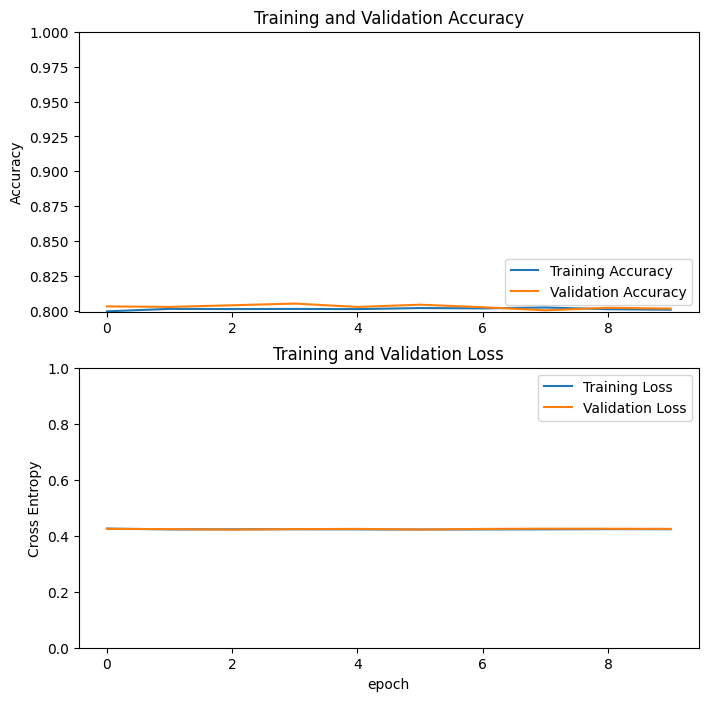

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()